@nipdep
## Model architecture

In [1]:
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import cv2
from scipy import io
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import RandomNormal, HeUniform
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, LeakyReLU, Activation, Dropout, BatchNormalization, LeakyReLU, GlobalMaxPool2D, Concatenate, ReLU, AveragePooling2D, GaussianNoise
from tensorflow.keras import losses

In [2]:
def define_generator(latent_size, input_size):
    init = RandomNormal(stddev=0.02)
    input_image = Input(shape=input_size, name='Input')
    noised_input = GaussianNoise(0.01, name='GausNoise')(input_image)
    
    hidden_layer = Conv2D(latent_size, (3,3), strides=(2,2), padding='same', name='HiddenLayer')(noised_input)
    hidden_activ = Activation('relu', name='HiddenActivation')(hidden_layer)

    output_layer = Conv2DTranspose(1, (3,3), strides=(2,2), padding='same', name='OutputLayer')(hidden_activ)
    output_activ = Activation('sigmoid', name='OutputActivation')(output_layer)

    model = Model(inputs=input_image, outputs=output_activ, name='defom_seg')
    return model

In [3]:
model = define_generator(16, (128,128,2))

In [4]:
model.summary()

Model: "defom_seg"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 2)]     0         
_________________________________________________________________
GausNoise (GaussianNoise)    (None, 128, 128, 2)       0         
_________________________________________________________________
HiddenLayer (Conv2D)         (None, 64, 64, 16)        304       
_________________________________________________________________
HiddenActivation (Activation (None, 64, 64, 16)        0         
_________________________________________________________________
OutputLayer (Conv2DTranspose (None, 128, 128, 1)       145       
_________________________________________________________________
OutputActivation (Activation (None, 128, 128, 1)       0         
Total params: 449
Trainable params: 449
Non-trainable params: 0
___________________________________________________________

## Dataset & dataLoader

In [5]:
train_data = np.load('../../data/data/train_data.npz')
fimg_data = train_data['first_image']
simg_data = train_data['second_image']
mask_data = train_data['mask']

In [6]:
fimg_data.shape

(848, 256, 256, 3)

In [7]:
## Optional to channel selection
f_np = fimg_data[...,0]
s_np = simg_data[...,1]

In [8]:
ff_np = np.expand_dims(f_np, 0)
sf_np = np.expand_dims(s_np, 0)
c_np = np.vstack((ff_np, sf_np))
n_np = np.moveaxis(c_np, [0,1,2,3], [3,0,1,2])
n_np.shape

(848, 256, 256, 2)

In [9]:
train_X = tf.data.Dataset.from_tensor_slices(n_np)
mask_y = tf.data.Dataset.from_tensor_slices(np.expand_dims(mask_data, -1))

In [10]:
train_dt = tf.data.Dataset.zip((train_X, mask_y))
train_dt.element_spec

(TensorSpec(shape=(256, 256, 2), dtype=tf.uint8, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint16, name=None))

In [11]:

def normalize(img, mask):
    # one, zero = tf.ones_like(mask), tf.zeros_like(mask)
    img = img/255
    # mask = mask/tf.math.reduce_max(mask)
    # mask = tf.where(mask > 0.0, x=one, y=zero)
    return tf.cast(img, dtype=tf.float32), tf.cast(mask, dtype=tf.float32)

def rescale(img, mask, scale=(128,128)):
    img = tf.image.resize(img, scale, preserve_aspect_ratio=True, antialias=True)
    mask = tf.image.resize(mask, scale, preserve_aspect_ratio=True, antialias=True)
    return tf.cast(img, dtype=tf.float32), tf.cast(mask, dtype=tf.float32)


def brightness(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_brightness(img1, 0.1)
#     img2 = tf.image.adjust_brightness(img2, 0.1)
    return img1, mask

def gamma(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_gamma(img1, 0.1)
#     img2 = tf.image.adjust_gamma(img2, 0.1) 
    return img1, mask

def hue(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.adjust_hue(img1, -0.1)
#     img2 = tf.image.adjust_hue(img2, -0.1)
    return img1, mask

# def crop(img, mask):
#      img = tf.image.central_crop(img, 0.7)
#      img = tf.image.resize(img, (128,128))
#      mask = tf.image.central_crop(mask, 0.7)
#      mask = tf.image.resize(mask, (128,128))
#      mask = tf.cast(mask, tf.uint8)
#      return img, mask

def flip_hori(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_left_right(img1)
#     img2 = tf.image.flip_left_right(img2)
        mask = tf.image.flip_left_right(mask)
    return img1, mask

def flip_vert(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.flip_up_down(img1)
#     img2 = tf.image.flip_up_down(img2)
        mask = tf.image.flip_up_down(mask)
    return img1, mask

def rotate(img1, mask):
    rnd = tf.random.uniform(shape=[], maxval=2, minval=0, dtype=tf.int32,seed=5)
    if rnd == 0:
        img1 = tf.image.rot90(img1)
#     img2 = tf.image.rot90(img2)
        mask = tf.image.rot90(mask)
    return img1, mask
# %%
# perform augmentation on train data only
train_dt = train_dt.map(normalize)
train_dt = train_dt.map(rescale)
a = train_dt.map(brightness)
b = train_dt.map(gamma)
e = train_dt.map(flip_hori)
f = train_dt.map(flip_vert)
g = train_dt.map(rotate)

train_dt = train_dt.concatenate(a)
train_dt = train_dt.concatenate(b)
train_dt = train_dt.concatenate(e)
train_dt = train_dt.concatenate(f)
train_dt = train_dt.concatenate(g) 

input image shape :  (128, 128, 2) mask image shape :  (128, 128, 1)


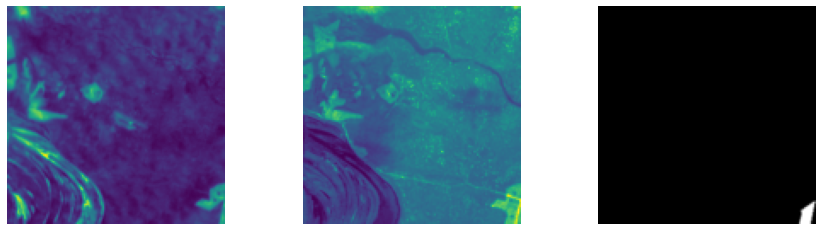

In [12]:
sample = train_dt.take(3)
sample_imgs = list(sample.as_numpy_iterator())
input_imgs = sample_imgs[2][0]
mask_img = sample_imgs[2][1]

plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(input_imgs[:, :, 0])

plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(input_imgs[:, :, 1])

plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(mask_img, cmap='gray', vmin=0, vmax=1)
fir_img = input_imgs[:, :,0]

## Model Training

In [13]:
BATCH = 32
AT = tf.data.AUTOTUNE
BUFFER = 1000
STEPS_PER_EPOCH = 800//BATCH
VALIDATION_STEPS = 200//BATCH
train_dt = train_dt.cache().shuffle(BUFFER).batch(BATCH).repeat()
train_dt = train_dt.prefetch(buffer_size=AT)

In [18]:
model = define_generator(32, (128,128,2))
model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [19]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 22ms/step - loss: 0.2374 - root_mean_squared_error: 0.4873
Epoch 2/10
25/25 [==============================] - 1s 27ms/step - loss: 0.1968 - root_mean_squared_error: 0.4436
Epoch 3/10
25/25 [==============================] - 1s 36ms/step - loss: 0.1488 - root_mean_squared_error: 0.3858
Epoch 4/10
25/25 [==============================] - 1s 46ms/step - loss: 0.1211 - root_mean_squared_error: 0.3480
Epoch 5/10
25/25 [==============================] - 2s 77ms/step - loss: 0.0935 - root_mean_squared_error: 0.3058
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 0.0699 - root_mean_squared_error: 0.2645
Epoch 7/10
25/25 [==============================] - 0s 12ms/step - loss: 0.0514 - root_mean_squared_error: 0.2267
Epoch 8/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860
Epoch 9/10
25/25 [==============================] - 0s 11ms/step - loss: 0.0269 - root_m

In [20]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


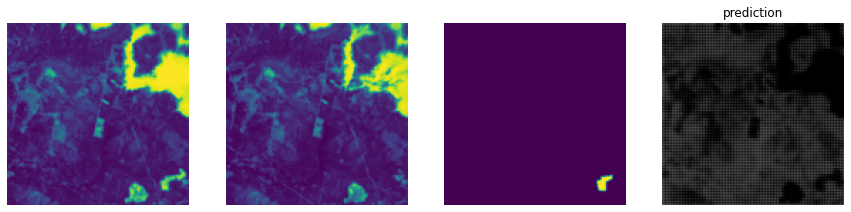

In [23]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
j = 4
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[j, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[j, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[j])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
plt.imshow(pred[j], cmap='gray', vmin=0, vmax=1)

### Using Dice-loss function

In [24]:
smooth = 1. # Used to prevent denominator 0
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true) # y_true stretch to one dimension
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [25]:
model = define_generator(32, (128,128,2))
model.compile(loss=dice_coef_loss,
             optimizer=keras.optimizers.Adam(5e-4),
             metrics=[tf.keras.metrics.RootMeanSquaredError()]) 

In [26]:
hist = model.fit(train_dt,
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=10)

Epoch 1/10
25/25 [==============================] - 1s 11ms/step - loss: 0.9705 - root_mean_squared_error: 0.4830
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 0.9633 - root_mean_squared_error: 0.4400
Epoch 3/10
25/25 [==============================] - 0s 11ms/step - loss: 0.9648 - root_mean_squared_error: 0.3996
Epoch 4/10
25/25 [==============================] - 0s 11ms/step - loss: 0.9597 - root_mean_squared_error: 0.3801
Epoch 5/10
25/25 [==============================] - 0s 11ms/step - loss: 0.9601 - root_mean_squared_error: 0.3474
Epoch 6/10
25/25 [==============================] - 0s 12ms/step - loss: 0.9569 - root_mean_squared_error: 0.3100
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 0.9432 - root_mean_squared_error: 0.2613
Epoch 8/10
25/25 [==============================] - 0s 14ms/step - loss: 0.9307 - root_mean_squared_error: 0.2095
Epoch 9/10
25/25 [==============================] - 0s 12ms/step - loss: 0.9175 - root_m

In [27]:
sample = train_dt.take(1)
sample_imgs = list(sample.as_numpy_iterator())[0]
f_imgs = sample_imgs[0]
mask_img = sample_imgs[1]
pred = model.predict(sample_imgs[0])

input image shape :  (128, 128, 2) mask image shape :  (32, 128, 128, 1)


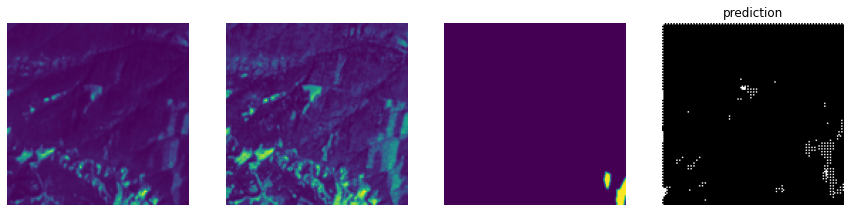

In [40]:
plt.figure(figsize=(15,4))
print("input image shape : ", input_imgs.shape, "mask image shape : ", mask_img.shape)
j = 13
ths = 0.25
plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(f_imgs[j, :, :, 0])

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(f_imgs[j, :, :, 1])

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(mask_img[j])

plt.subplot(1, 4, 4)
plt.axis('off')
plt.title("prediction")
mask = (pred[j]>ths).astype('uint8')
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

In [41]:
model.save_weights('../../data/models/defo_mask3.h5')